In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

import fredapi as fa
from local_settings import fred as settings
fred = fa.Fred(settings['api_key'])

In [3]:
tickers = []

with open('tickers.txt') as f:
    for line in f:
        tickers.append(line.strip())

In [4]:
assets = {}

for ticker in tickers:
    assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

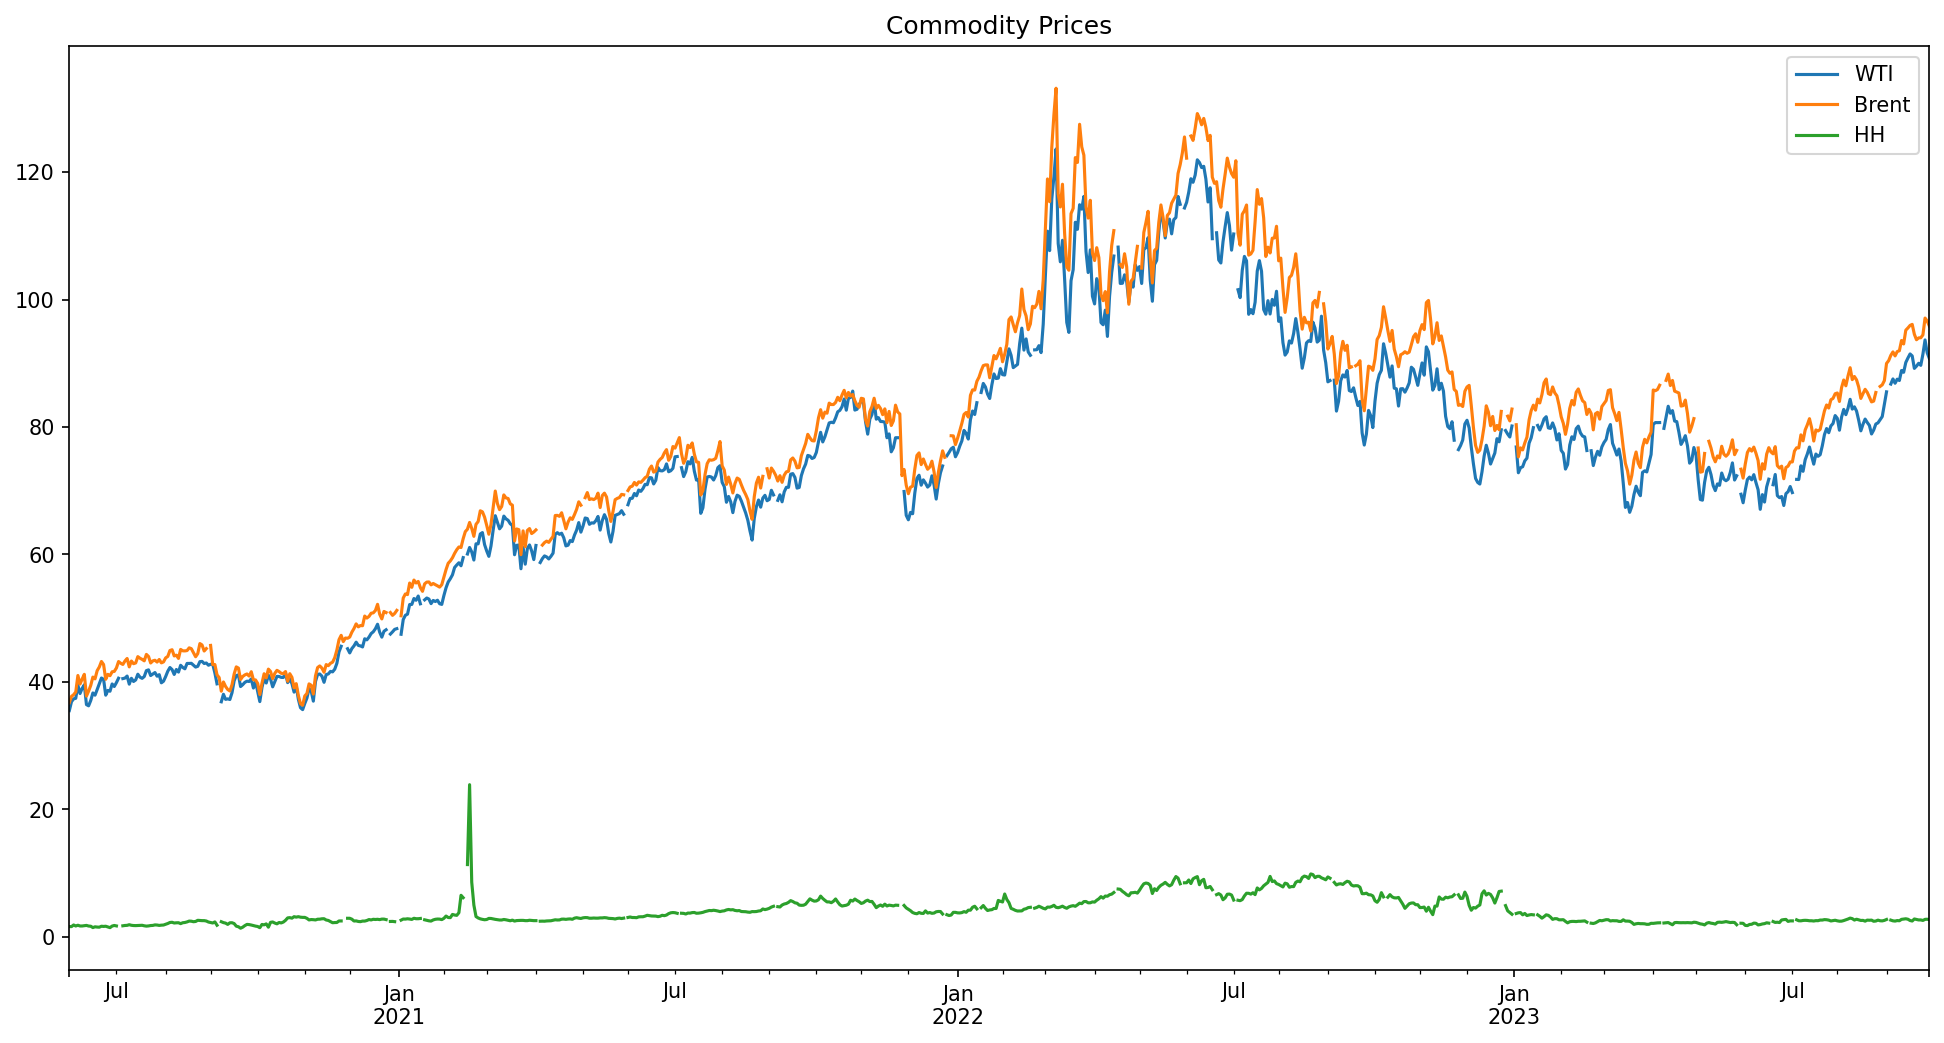

In [5]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

In [6]:
returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

DCOILWTICO  DCOILBRENTEU  DHHNGSP  Ret_DCOILWTICO   
2020-06-02       36.88         37.72     1.58        0.038418  \
2020-06-03       37.33         37.98     1.84        0.012128   
2020-06-04       37.42         38.41     1.68        0.002408   
2020-06-05       39.49         41.00     1.80        0.053842   
2020-06-08       38.17         39.66     1.68       -0.033998   

            Ret_DCOILBRENTEU  Ret_DHHNGSP  
2020-06-02          0.026324    -0.006309  
2020-06-03          0.006869     0.152341  
2020-06-04          0.011258    -0.090972  
2020-06-05          0.065254     0.068993  
2020-06-08         -0.033229    -0.068993

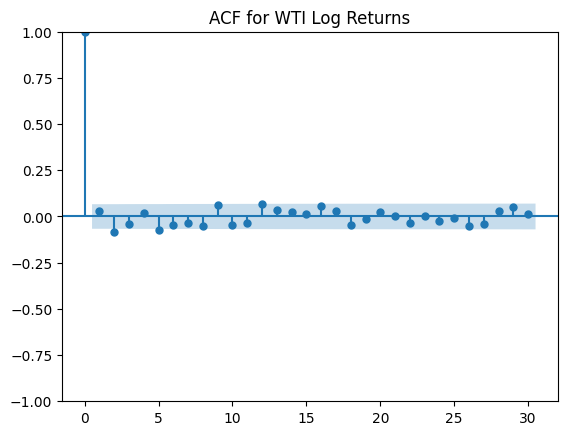

In [7]:
series_wti = returns['Ret_DCOILWTICO']

acf_ret_wti = acf(series_wti)
plot_acf(series_wti, lags=30, title='ACF for WTI Log Returns')
plt.show()

ACF of log returns indicates some AR/MA property among returns with lags 2, 5, 9, 12 being statistically significant

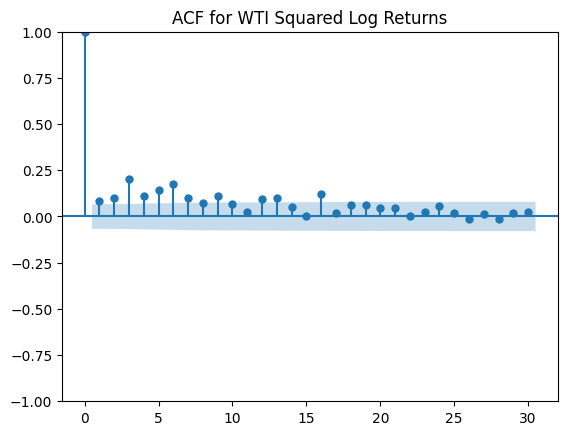

In [9]:
acf_retsq_wti = acf(series_wti**2)
plot_acf(series_wti**2, lags=30, title='ACF for WTI Squared Log Returns')
plt.show()

ACF of squared log returns indicates some AR property among squared returns for (G)ARCH with lags up to 9 and several others being statistically significant

In [10]:
describe(series_wti)

Ret_DCOILWTICO
nobs                8.690000e+02
missing             0.000000e+00
mean                1.080642e-03
std_err             8.235387e-04
upper_ci            2.694748e-03
lower_ci           -5.334643e-04
std                 2.427694e-02
iqr                 2.791480e-02
iqr_normal          2.069327e-02
mad                 1.793358e-02
mad_normal          2.247641e-02
coef_var            2.246529e+01
range               2.099119e-01
max                 8.214099e-02
min                -1.277709e-01
skew               -6.086903e-01
kurtosis            5.222853e+00
jarque_bera         2.325694e+02
jarque_bera_pval    3.149179e-51
mode                0.000000e+00
mode_freq           4.027618e-02
median              2.277669e-03
1%                 -7.150836e-02
5%                 -3.960562e-02
10%                -3.064182e-02
25%                -1.134888e-02
50%                 2.277669e-03
75%                 1.656592e-02
90%                 2.688840e-02
95%                 3.594296e-02
99%                 5.726188e-02

negative skewness

high kurtosis

jarque_bera_pval close to zero --> H0 normality rejected

In [12]:
mu, sigma = np.mean(series_wti), np.std(series_wti)
x = np.random.normal(mu, sigma, 1000)
x = pd.Series(x, name='Normal Distribution')

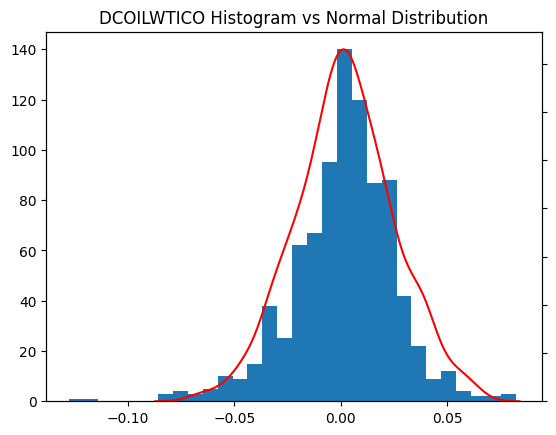

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
ax1.hist(series_wti, bins=30)
g1 = sns.kdeplot(x, ax=ax2, color='r')
g1.set(ylabel=None)
g1.set(yticklabels=[])
plt.title('DCOILWTICO Histogram vs Normal Distribution');

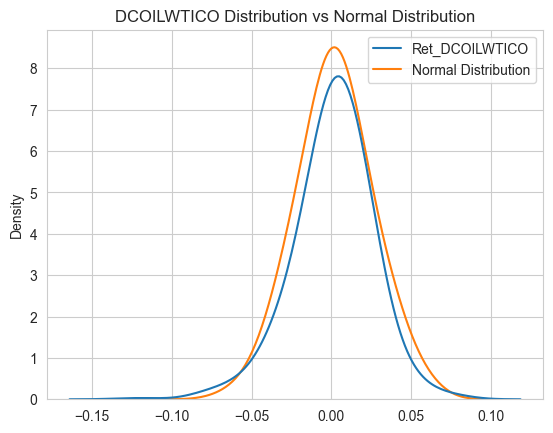

In [14]:
sns.set_style('whitegrid')
series_wti_norm = pd.concat([series_wti, x], axis=1)
sns.kdeplot(data=series_wti_norm, bw_method=0.5)
plt.title('DCOILWTICO Distribution vs Normal Distribution');

Leptokurtic distribution

Negative skew

Fat tails, particularly for negative returns

In [15]:
arch_test = het_arch(series_wti)
arch_test

(74.01086220849128,
 7.409383379921156e-12,
 7.995169376403505,
 2.158539007848078e-12)

In [16]:
arch_test = het_arch(series_wti, nlags=5)
arch_test

(58.30251863526131,
 2.7243829457468232e-11,
 12.417454974371093,
 1.1881259650242177e-11)

H0 no arch effects rejected (p-value close to zero)

In [8]:
proportion_in_train = 0.9
split = int(proportion_in_train*len(series_wti))

series_wti_train = series_wti.iloc[:split]
series_wti_test = series_wti.iloc[split+1:]

In [50]:
class garch:
    def __init__(self, p, q, mean, train, test):
        self.p = p
        self.q = q
        self.mean = mean
        self.train = train
        self.test = test
        self.res_garch = self.fit()
        self.forecast = self.forecast()
        self.forecast_vs_test = self.forecast_vs_test()
    
    def fit(self):
        garch = arch.arch_model(self.train, mean=self.mean, vol='GARCH', p=self.p, q=self.q)
        res_garch = garch.fit()
                
        return res_garch

    def summary(self):
        res_garch_summary = self.res_garch.summary()
        
        return res_garch_summary
    
    def plot(self):
        fig = self.res_garch.plot()
        
        return fig
    
    def autocorr(self):
        lb = acorr_ljungbox(self.res_garch.std_resid**2, [10, 15, 20])
        
        return lb
    
    def info_crit(self):
        ic_out = {'AIC': [self.res_garch.aic], 'BIC': [self.res_garch.bic]}
        ic = pd.DataFrame(data=ic_out)
        
        return ic
    
    def acf_stan(self):
        plot_acf(self.res_garch.std_resid, lags=30, title='ACF of Standardized Residuals')
        plt.show()
        
    def acf_sq_stan(self):
        plot_acf(self.res_garch.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
        plt.show()
        
    def forecast(self):
        forecast = self.res_garch.forecast(horizon=len(self.test))
        
        return forecast
    
    def forecast_mean(self):
        forecast_mean = self.forecast.mean
        forecast_mean.iloc[0].plot()
        
    def forecast_stdev(self):
        forecast_stdev = self.forecast.variance**0.5
        forecast_stdev.iloc[0].plot()
    
    def forecast_vs_test(self):
        forecast_mean = pd.Series(self.forecast.mean.iloc[0].values, index=self.test.index)
        self.train.rename('Ret_Train', inplace=True)
        self.test.rename('Ret_Test', inplace=True)
        forecast_mean.rename('Ret_Forecast', inplace=True)
        forecast_vs_test = pd.concat([self.train, self.test, forecast_mean], axis=1)

        forecast_vs_test['Ret_Test_Broad'] = forecast_vs_test[['Ret_Train','Ret_Test']].max(axis=1)

        forecast_vs_test['Vol_Train'] = forecast_vs_test[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test_Broad'] = forecast_vs_test[['Ret_Test_Broad']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test'] = np.where(forecast_vs_test['Ret_Test'].isna(), forecast_vs_test['Ret_Test'], forecast_vs_test['Vol_Test_Broad'])

        forecast_vs_test_condvol = pd.Series((self.forecast.variance**0.5).iloc[0].values, index=self.test.index) #conditional vol
        forecast_vs_test_condvol.rename('Vol_Forecast', inplace=True)
        forecast_vs_test = pd.concat([forecast_vs_test, forecast_vs_test_condvol], axis=1)

        return forecast_vs_test
    
    def forecast_vs_test_mean_plot(self):
        self.forecast_vs_test[['Ret_Train','Ret_Test','Ret_Forecast']].plot()
        
    def forecast_vs_test_vol_plot(self):
        self.forecast_vs_test[['Vol_Train','Vol_Test','Vol_Forecast']].plot()

In [51]:
garch11 = garch(1, 1, 'Zero', series_wti_train, series_wti_test)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1809.999300967107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.999301378689
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [51]:
garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1810.00
Distribution:                  Normal   AIC:                          -3614.00
Method:            Maximum Likelihood   BIC:                          -3600.01
                                        No. Observations:                  782
Date:                Sun, Dec 03 2023   Df Residuals:                      782
Time:                        14:38:53   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2330e-05  1.267e-05      4.918  8.741e-07 [3.749e-05,8.717e-05]
alpha[1]       0.1000  2.641e-02      3.786  1.531e-04   [4.823e-02,  0.152]
beta[1]        0.8000  2.713e-02     29.485 4.478e-191     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

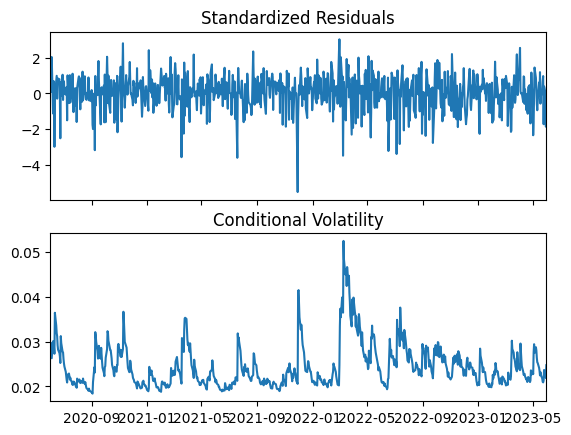

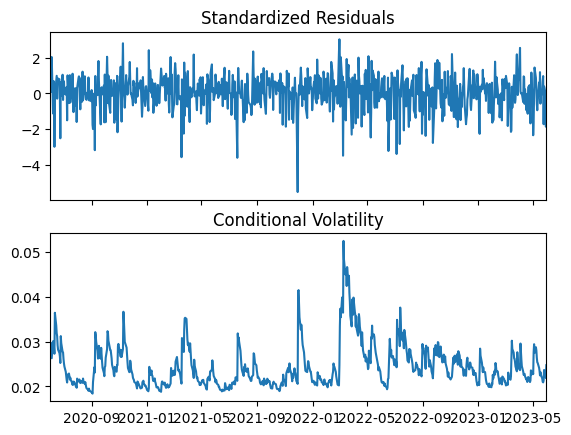

In [54]:
garch11.plot()

In [55]:
garch11.autocorr()

lb_stat  lb_pvalue
10   5.827400   0.829550
15  10.114137   0.812500
20  12.494963   0.897987

In [56]:
garch11.info_crit()

AIC          BIC
0 -3613.998603 -3600.013039

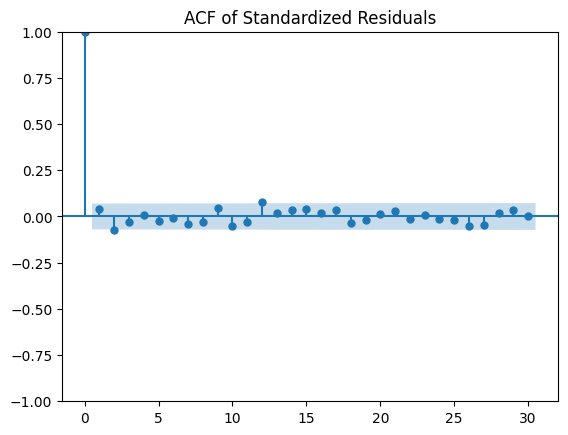

In [57]:
garch11.acf_stan()

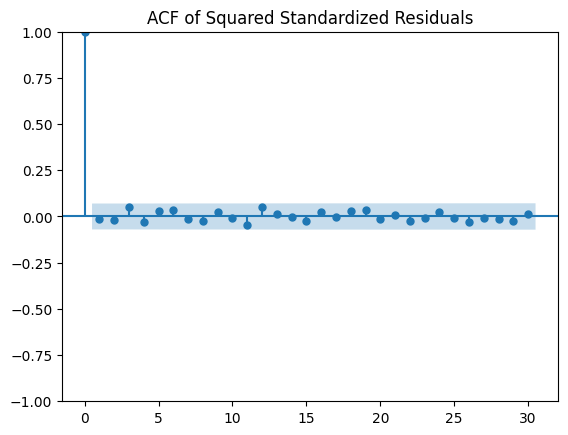

In [58]:
garch11.acf_sq_stan()

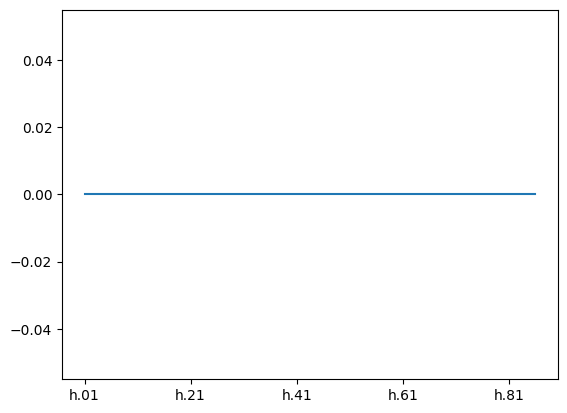

In [58]:
garch11.forecast_mean()

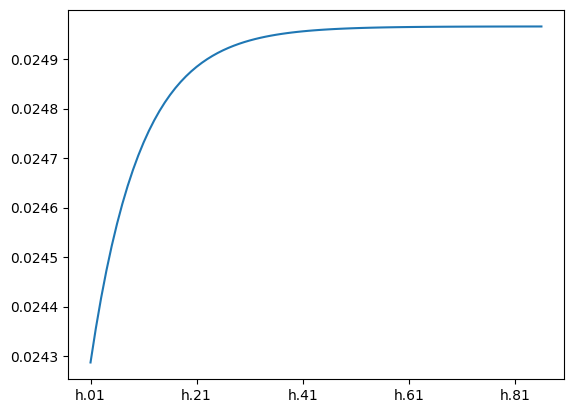

In [59]:
garch11.forecast_stdev()

In [49]:
garch11.forecast_vs_test

Ret_Train  Ret_Test  Ret_Forecast  Ret_Test_Broad  Vol_Train   
2020-06-02   0.038418       NaN           NaN        0.038418        NaN  \
2020-06-03   0.012128       NaN           NaN        0.012128        NaN   
2020-06-04   0.002408       NaN           NaN        0.002408        NaN   
2020-06-05   0.053842       NaN           NaN        0.053842        NaN   
2020-06-08  -0.033998       NaN           NaN       -0.033998        NaN   
...               ...       ...           ...             ...        ...   
2023-09-25        NaN -0.003562           0.0       -0.003562        NaN   
2023-09-26        NaN  0.019326           0.0        0.019326        NaN   
2023-09-27        NaN  0.024204           0.0        0.024204        NaN   
2023-09-28        NaN -0.021801           0.0       -0.021801        NaN   
2023-09-29        NaN -0.009648           0.0       -0.009648        NaN   

            Vol_Test_Broad  Vol_Test  Vol_Forecast  
2020-06-02             NaN       NaN           NaN  
2020-06-03             NaN       NaN           NaN  
2020-06-04             NaN       NaN           NaN  
2020-06-05             NaN       NaN           NaN  
2020-06-08             NaN       NaN           NaN  
...                    ...       ...           ...  
2023-09-25        0.012104  0.012104      0.024966  
2023-09-26        0.011994  0.011994      0.024966  
2023-09-27        0.011721  0.011721      0.024966  
2023-09-28        0.011317  0.011317      0.024966  
2023-09-29        0.012269  0.012269      0.024966  

[868 rows x 8 columns]

In [53]:
garch11.forecast_vs_test_mean_plot()

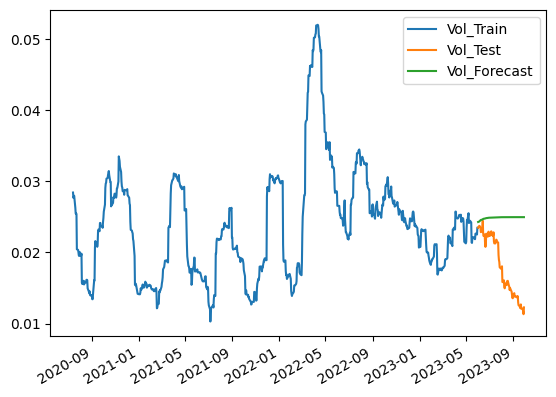

In [54]:
garch11.forecast_vs_test_vol_plot()

All coefficients are statistically significant at 5% confidence level after removing the insignificant mean equation constant

Ljung-Box test on squared standardised residuals: H0 no autocorrelation not rejected at 5% at all 10, 15 & 20 lags

ACF of squared standardised residuals suggests the conditional variance equation is complete - although will see what GARCH(2,1) & GARCH(1,2) produce

ACF of standardised residuals suggets the mean equation can be modified - AR(2), AR(12) to be added

Prediction is run for the chosen number of days from the last available observation by default. The mean equation continues to be 0 as per the zero mean equation definition at the model setup stage. The variance equation evolves according to GARCH(1,1).